# makemore: part 3


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
# read in all the words
words = open("names.txt", "r").read().splitlines()
words[:8]

In [ ]:
len(words)

In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

### Processing dataset


In [ ]:
# build the dataset
block_size = (
    3  # context length: how many characters do we take to predict the next one?
)


def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])  # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10% # to test parameterisation
Xte, Yte = build_dataset(words[n2:])  # 10%

### Define MLP


`* 0.01` used through out to prevent dead neuron and to ensure activation (not in flat region of activation function) for more examples


In [83]:
# MLP revisited
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = (
    torch.randn((n_embd * block_size, n_hidden), generator=g)
    * (5 / 3)
    / ((n_embd * block_size) ** 0.5)
) * 0.01
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = (
    torch.randn((n_hidden, vocab_size), generator=g) * 0.01
)  # to ensure W2 close to zero (don't want to set weights to zero!)
b2 = torch.randn(vocab_size, generator=g) * 0  # to ensure b2 initially zero

# !!! Batch Norm !!! → normalizes preactivations (we want this for initialization)
# !!! Affine parameters
bngain = torch.ones(
    (1, n_hidden)
)  # param that will be learnt with backprop to normalization pre-activatios
bnbias = torch.zeros(
    (1, n_hidden)
)  # param that will be learnt with backprop to normalization pre-activatios

# "buffers"
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

12097


In [74]:
# can test if initalisation is poor by testing loss of equiprobable parameter distribution
# 4-dimensional example of problem
logits = (
    torch.randn(4) * 10000
)  # very high logit values ie: counts can cause numerical instability
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

# we actually want logits approx equal at initialisation

(tensor([0., 0., 0., 1.]), tensor(inf))

- In Neural Networks there is generally a loss expected at initialisation
- This should be the loss if all paramas are equiprobable
- Want to avoid **"hockey stick shape"** → network is very confidently wrong

### Simple 4D example of issue

---

- Understanding the relationship between `logits`, `prob` & `loss`


In [75]:
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(
    logits, dim=0
)  # we get probabilities that are a diffused distribution
loss = -probs.log()  # notice that loss is the same over all dimensions
logits, probs, loss

(tensor([0., 0., 0., 0.]),
 tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor([1.3863, 1.3863, 1.3863, 1.3863]))

In [76]:
logits = torch.randn(4)
probs = torch.softmax(
    logits, dim=0
)  # we get probabilities that are a diffused distribution
loss = -probs.log()  # notice that loss is the same over all dimensions
logits, probs, loss

(tensor([ 1.5385,  2.6814, -0.5408, -0.9588]),
 tensor([0.2302, 0.7220, 0.0288, 0.0190]),
 tensor([1.4686, 0.3257, 3.5479, 3.9659]))

### **Issue 1:** Extreme `logits` (confidently wrong) → ∞ `loss` → **Dead Neuron** 😵


In [77]:
logits = torch.randn(4) * 100
probs = torch.softmax(
    logits, dim=0
)  # we get probabilities that are a diffused distribution
loss = -probs.log()  # notice that loss is the same over all dimensions
logits, probs, loss

(tensor([-145.5075, -340.1197,   92.6701, -183.0347]),
 tensor([0., 0., 1., 0.]),
 tensor([inf, inf, -0., inf]))

### Want `logits ≃ 0` (or equal-ish)

### In our model, above, we have `logits = h @ W2 + b2`

### We use `b2 * 0` and `W2 * 0.0001` to ensure `logits` close to zero → initialization loss is much better

### We don't use `W2 * 0` as we want `loss` to have _some_ entropy

---

### Training loop


In [78]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1  # + b1 # hidden layer pre-activation

    # BatchNorm layer
    # -------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    # we create running batch normalization statistics
    # these are not used for training, only for evaluation
    with torch.no_grad():
        # 0.999 is momentum; helps to stablise smaller batch sizes where sample stats different to dataset stats
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact)  # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    # break  # we use this break when testing the initialisation

      0/ 200000: 3.3147
  10000/ 200000: 2.2104
  20000/ 200000: 2.3520
  30000/ 200000: 2.4913
  40000/ 200000: 1.9712
  50000/ 200000: 2.3807
  60000/ 200000: 2.5079
  70000/ 200000: 2.1124
  80000/ 200000: 2.3587
  90000/ 200000: 2.1722
 100000/ 200000: 1.8619
 110000/ 200000: 2.3152
 120000/ 200000: 1.9091
 130000/ 200000: 2.4509
 140000/ 200000: 2.3524
 150000/ 200000: 2.2249
 160000/ 200000: 1.9774
 170000/ 200000: 1.9437
 180000/ 200000: 1.9646
 190000/ 200000: 1.8351


### **Issue 2:** Check activation of hidden layer `h`


In [ ]:
plt.hist(h.view(-1).tolist(), bins=50)

#### most values take -1 or 1 → `tanh` very "active"

#### Very bad for backprop!!! → derivative of `tanh` is (1-t^2)\*out.grad → when t^2 close to 1 → **zero gradient → stops backprop**

- We are in the flat region of the `tanh` → small gradient


In [ ]:
plt.hist(hpreact.view(-1).tolist(), bins=50)

### Range of pre-activations show the extreme values that are "squashed" in our `tanh` activation


What to avoid "Hockey stick loss" → evidence of poor initialisation (easy gains initially by squashing `logits`)

### Leads to better optimization for limited training epochs


In [ ]:
plt.plot(lossi)

### If too many elements of array > 0.99 → `W` & `b`do not impact loss much → "dead neuron"


In [ ]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")

- A full white line → dead neuron → `tanh` very active and backward gradient destoryed → no single

#### If the gradient zeros out → will not learn! → `Ws` & `bs` will never get a gradient

(can occur when poor initialisation or too big learning rate; "permanent brain damage --> Leaky Relu doesn't have this issue → no flat region)


### Activation should in central region to get best learning

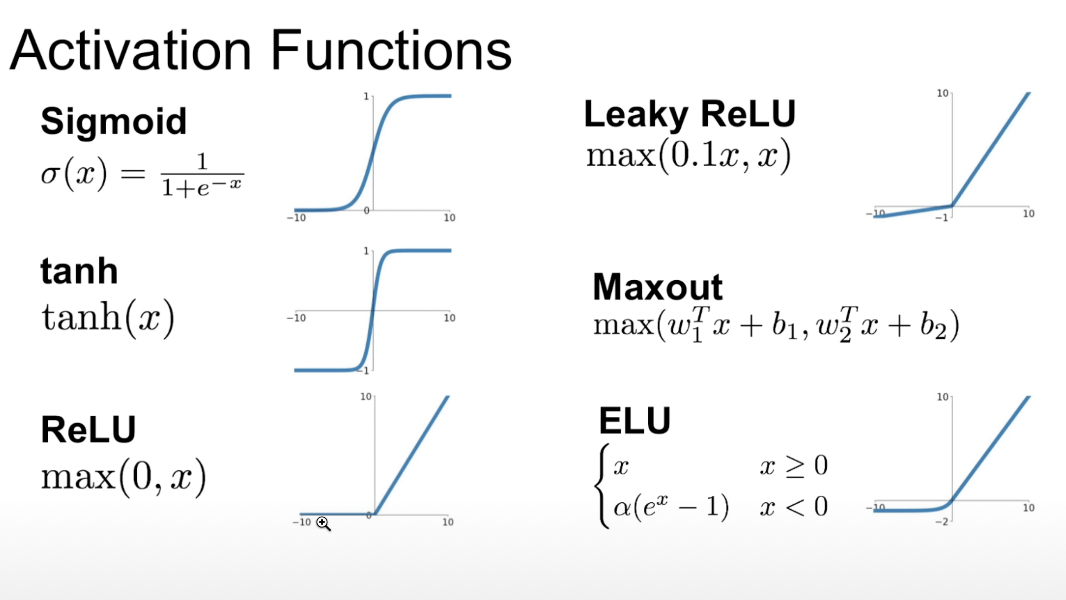


### Batch Normalisation: Stablises training

- Add Batch Norm layers after linear and convolutional layers (??? perhaps before activations ???)
- Examples in batch coupled together in forward pass; no longer processes one-by-one → but `bnmeani` and `bnstdi` now depend on random sampling of batch → leads to strange mathematical properties

* Pads out example
* Regularizes the pre-activation
* Form of data-augmentation

Alternative Nomalisation techniques that don't couple batch examples:

- Layer normalization
- Instance normalization
- Group normalization

But Batch Norm works well!


In [ ]:
# calibrate the batch norm at the end of training

with torch.no_grad():  # context manager to disable gradient tracking
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1  # + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

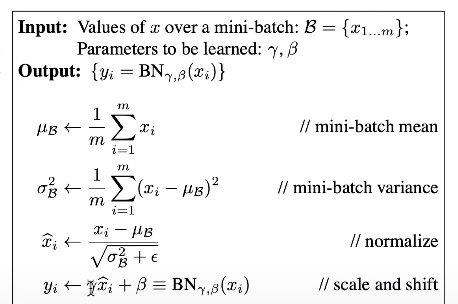


Batch Normalization v2

- Related to prediction of 1 values, despite the fact that training is done in batches

* If Batch Normalization is used, linear layers shouldn't include a bias `b`, since it is normalized out; instead we use the Batch Normalization bias


In [ ]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    emb = C[x]  # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)  # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1  # + b1
    # !!! Batch Normalization v1 →  Batch Mean & Std !!!
    # hpreact = (bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias)

    # !!! Batch Normalization v2 →  Running Mean & Std !!! So we don't need to calibrate after training
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)  # (N, n_hidden)
    logits = h @ W2 + b2  # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")

> # Loss log
>
> Things we have done to improve the loss and to make learning cycles most efficient
>
> **This is important for more complex, deeper networks!!!**
>
> ### original:
>
> `train: 2.1245384216308594` > `val: 2.168196439743042`
>
> ### fix softmax confidently wrong:
>
> `train: 2.07` > `val: 2.13`
>
> ### fix tanh layer too saturated at init:
>
> `train: 2.0355966091156006` > `val: 2.1026785373687744`
>
> ### use semi-principled "kaiming init" instead of hacky init:
>
> `train: 2.0376641750335693` > `val: 2.106989622116089`
>
> ### add batch norm layer
>
> `train: 2.0668270587921143` > `val: 2.104844808578491`


Principled view of setting scalar weights on `Ws` & `bs`


tensor(0.0260) tensor(0.9958)
tensor(0.0117) tensor(3.1892)


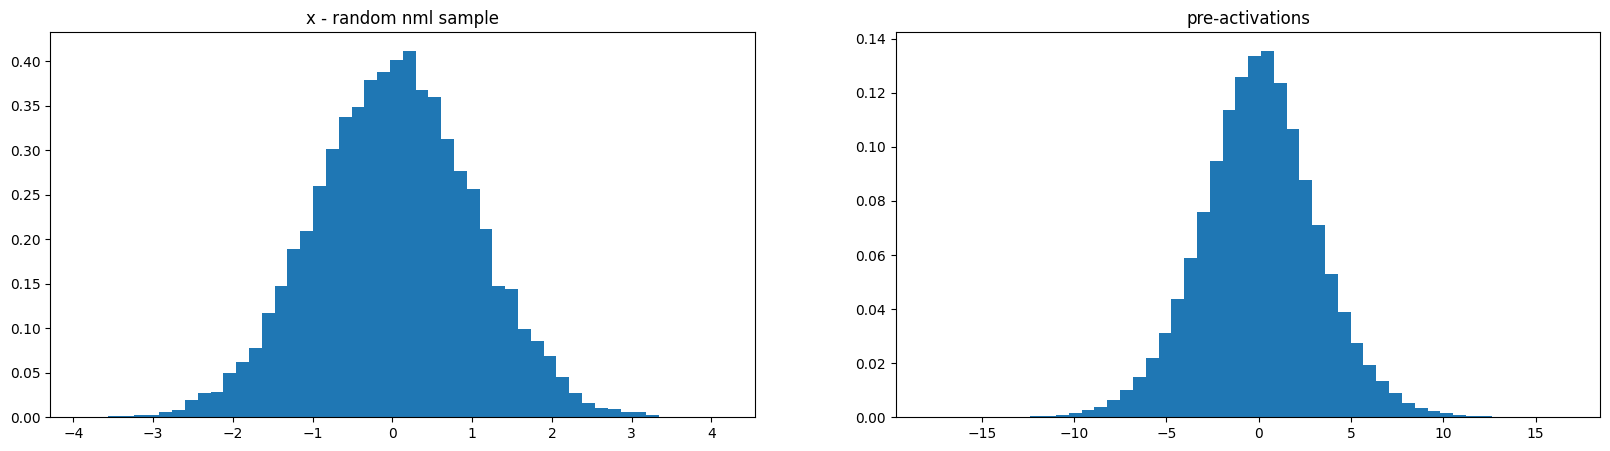

In [82]:
x = torch.randn(1000, 10)
factor = 1  # factor ends up being the resultant std dev of x (see torch.nn.init.kaiming_normal)
w = torch.randn(10, 200) * factor
# what factor to preserve std dev of x in pre-activations
y = x @ w  # pre-activations
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121, title="x - random nml sample")
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122, title="pre-activations")
plt.hist(y.view(-1).tolist(), 50, density=True)

- Guassian has expanded in pre-activations

Proper initialisation has become less of issue due to:

- Residual connections
- Batch/ Layer Normalisation
- Better optimisers

#### Practically

- Normalise weights by `√fan_in` (`fan_in` is `N`: In PyTorch, "fan_in" refers to the number of input units in a weight tensor.)

https://pytorch.org/docs/stable/nn.init.html --> kaiming init!

Gains:
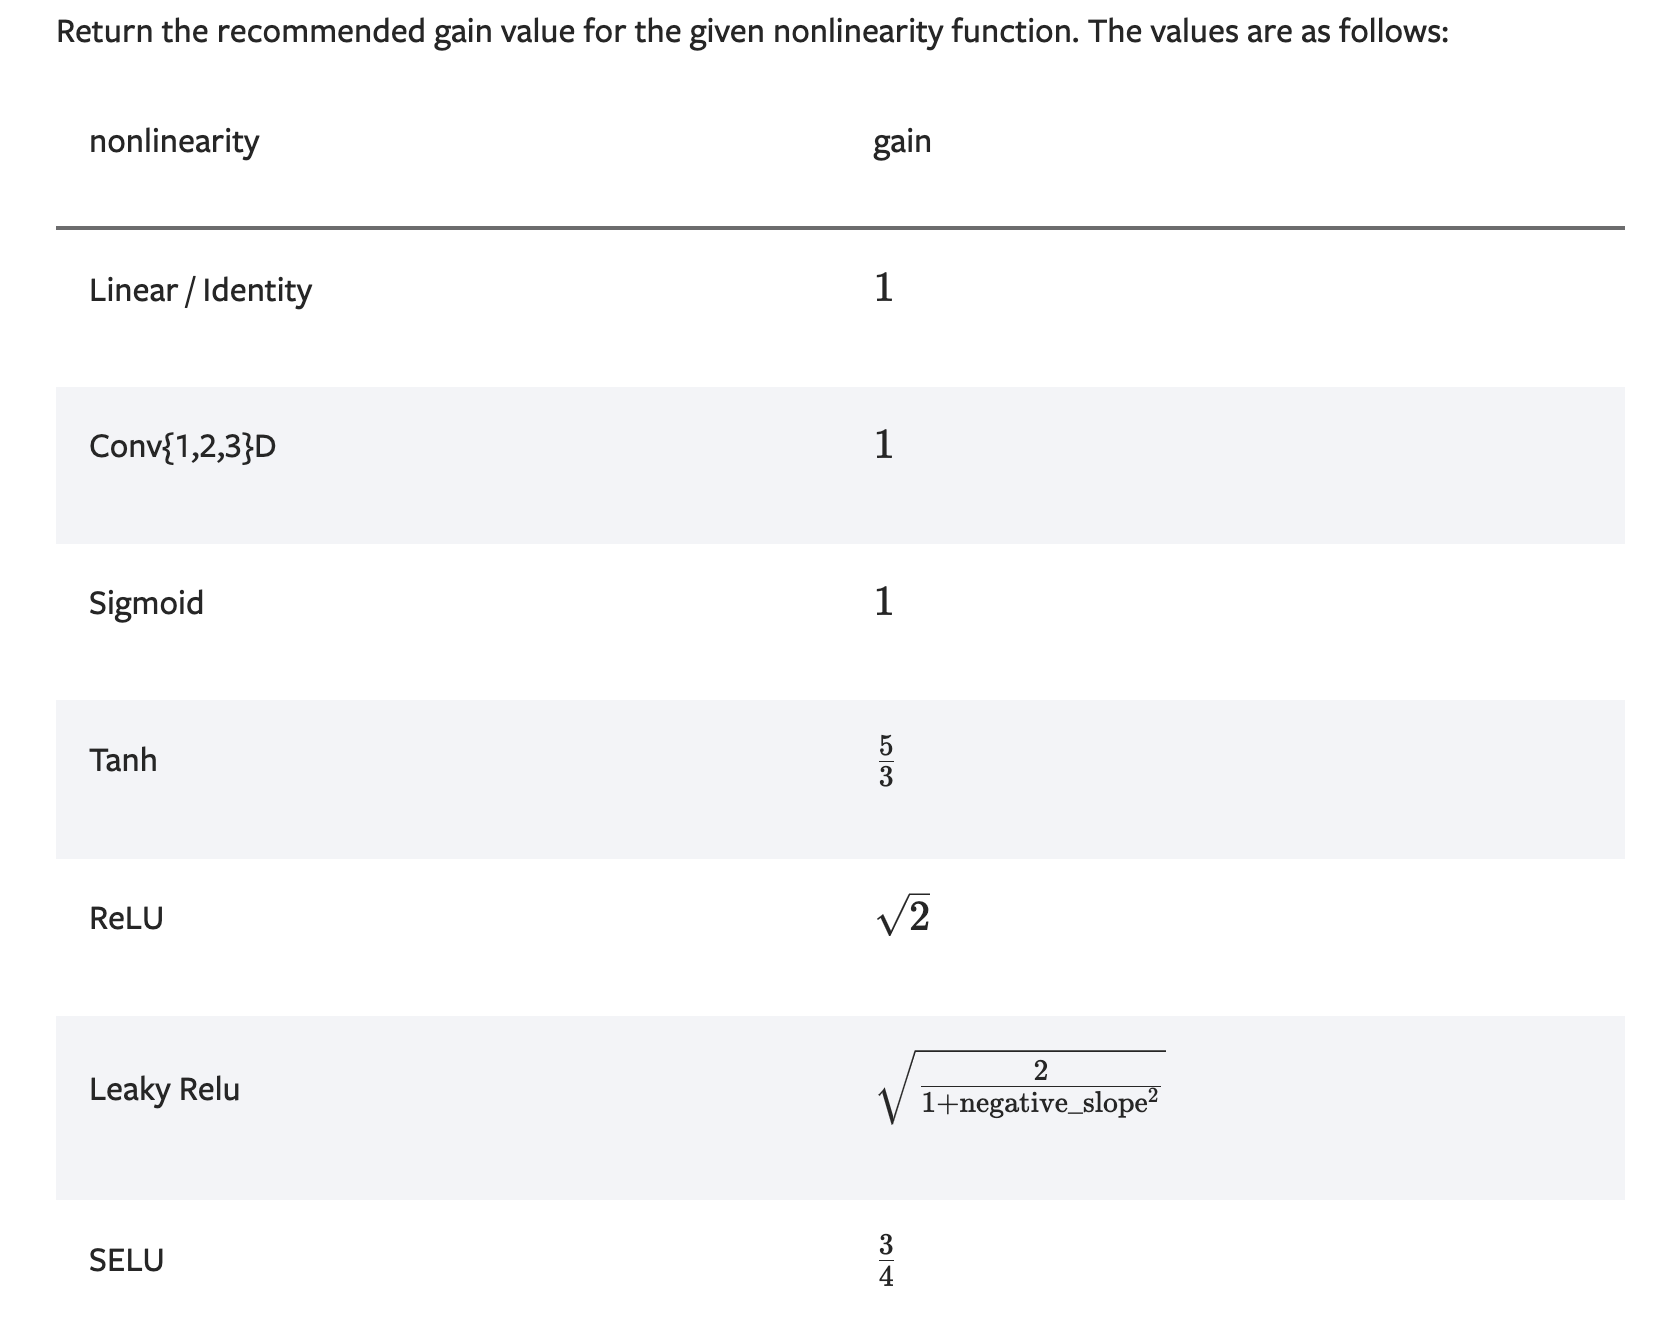


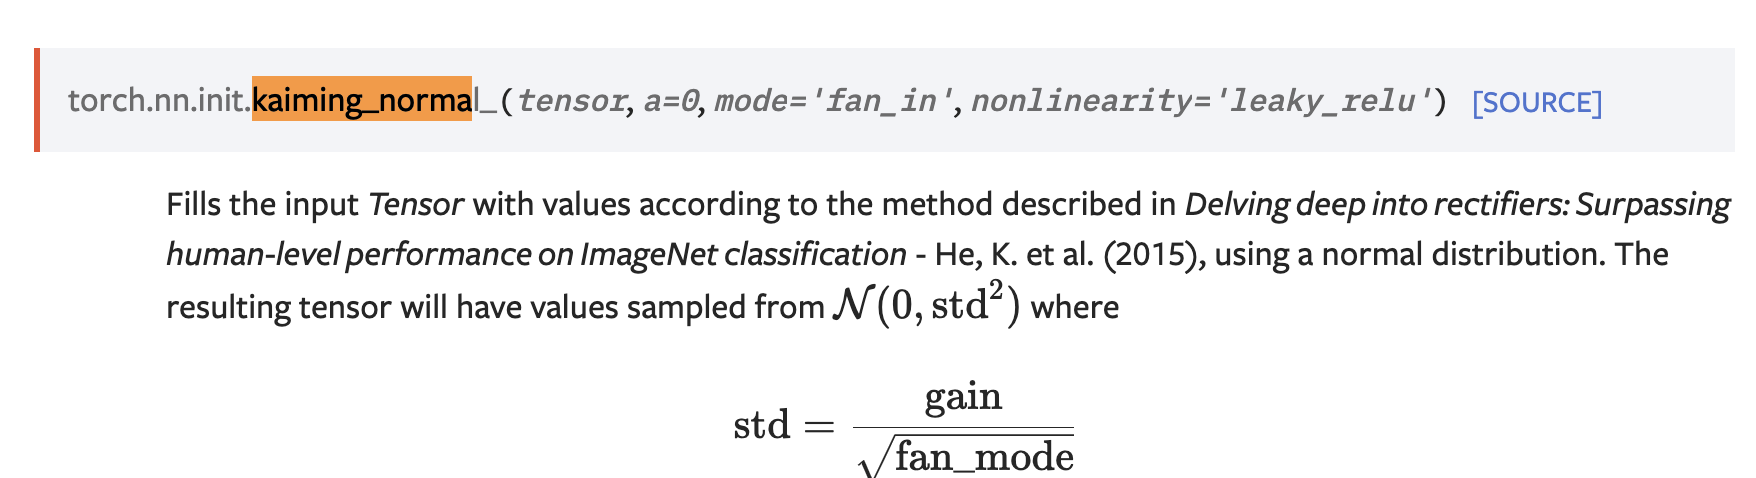


We can just normlise the pre-activations


# `pytorch`-ify!!!


In [ ]:
# SUMMARY + PYTORCHIFYING -----------

### `pytorch`-like classes


In [94]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch
# Attibute .out is not a typical pytorch method; included here for plotting statistics of layer activations


class Linear:
    """
    very similar to torch.nn.Linear
    https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
    """

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    """
    very similar to torch.nn.BatchNorm1d
    https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html
    """

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = (
            True  # many modules have different behaviour during training and evaluation
        )
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # "buffers" (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        # "buffers" trained exponential moving average; not part of backprop

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)  # batch mean
            xvar = x.var(0, keepdim=True)  # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                # so we don't use unnecessary  memory
                self.running_mean = (
                    1 - self.momentum
                ) * self.running_mean + self.momentum * xmean
                self.running_var = (
                    1 - self.momentum
                ) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]  # but NOT self.running_mean, self.running_var


class Tanh:
    """
    torch.tanh
    """

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 100  # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)  # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size, bias=False),
    BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    # layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1  # 5 / 3

parameters = [C] + [
    p for layer in layers for p in layer.parameters()
]  # double list comprehension
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

47024


### Training loop


In [95]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    x = emb.view(emb.shape[0], -1)  # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append(
            [((lr * p.grad).std() / p.data.std()).log10().item() for p in parameters]
        )

    if i >= 1000:
        break  # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870


### Forward pass of `tanh` activations

- Saturations are in the tail of `tanh` gradients → unwanted
- Pattern of stabilizing dbn (std drops) through the layers is because gain is set to 5/3
- Activations squash the dbns at each stage


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.78%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.56%
layer 8 (      Tanh): mean -0.00, std 0.65, saturated: 2.25%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.69%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.88%


Text(0.5, 1.0, 'activation distribution')

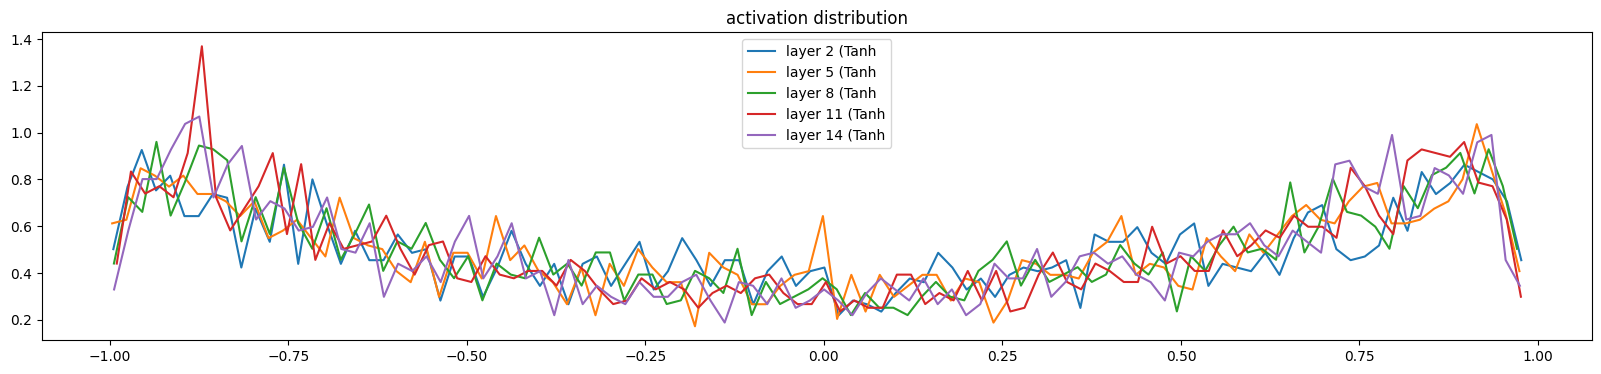

In [99]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print(
            "layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%"
            % (
                i,
                layer.__class__.__name__,
                t.mean(),
                t.std(),
                (t.abs() > 0.97).float().mean() * 100,
            )
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__}")
plt.legend(legends)
plt.title("activation distribution")

layer 2 (      Tanh): mean -0.000000, std 2.640703e-03
layer 5 (      Tanh): mean +0.000000, std 2.245585e-03
layer 8 (      Tanh): mean +0.000000, std 2.045743e-03
layer 11 (      Tanh): mean -0.000000, std 1.983134e-03
layer 14 (      Tanh): mean +0.000000, std 1.952382e-03


Text(0.5, 1.0, 'gradient distribution')

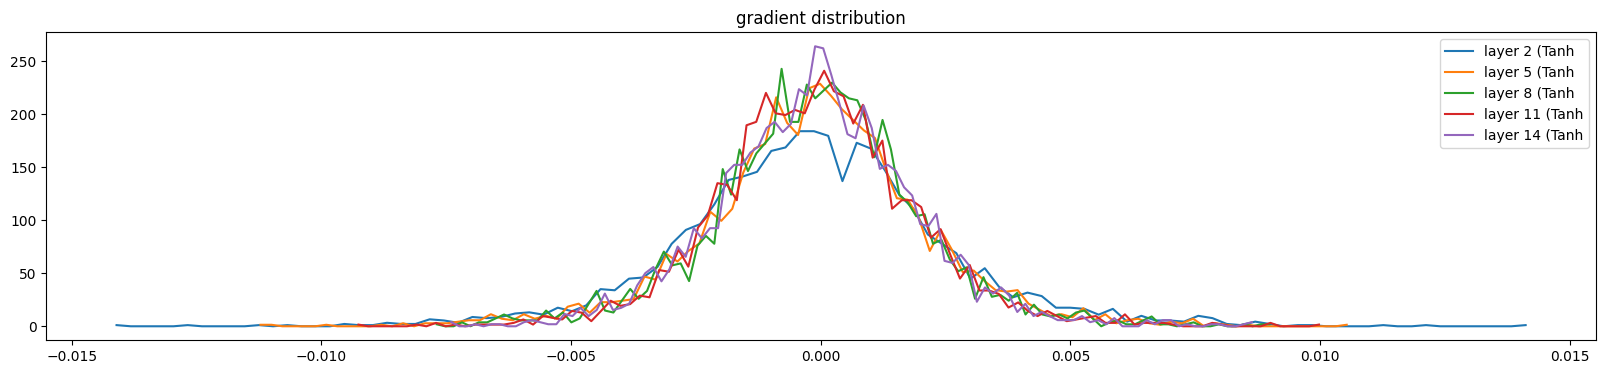

In [97]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(
            "layer %d (%10s): mean %+f, std %e"
            % (i, layer.__class__.__name__, t.mean(), t.std())
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__}")
plt.legend(legends)
plt.title("gradient distribution")

weight   (27, 10) | mean +0.000000 | std 8.020536e-03 | grad:data ratio 8.012632e-03
weight  (30, 100) | mean +0.000246 | std 9.241076e-03 | grad:data ratio 4.881090e-02
weight (100, 100) | mean +0.000113 | std 7.132879e-03 | grad:data ratio 6.964620e-02
weight (100, 100) | mean -0.000086 | std 6.234305e-03 | grad:data ratio 6.073741e-02
weight (100, 100) | mean +0.000052 | std 5.742188e-03 | grad:data ratio 5.631484e-02
weight (100, 100) | mean +0.000032 | std 5.672206e-03 | grad:data ratio 5.570126e-02
weight  (100, 27) | mean -0.000082 | std 1.209416e-02 | grad:data ratio 1.160106e-01


Text(0.5, 1.0, 'weights gradient distribution')

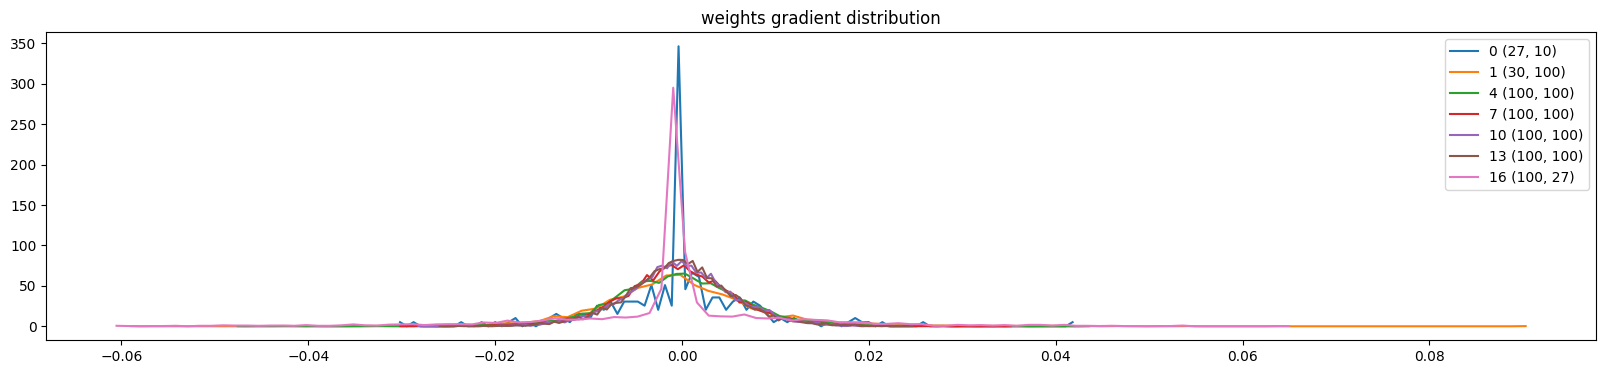

In [101]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print(
            "weight %10s | mean %+f | std %e | grad:data ratio %e"
            % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std())
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} {tuple(p.shape)}")
plt.legend(legends)
plt.title("weights gradient distribution")

- Update ratios reveal if learning rate is too low/ high
- Shows relative speed at which layers are learning
- Shows poor learning rate calibration


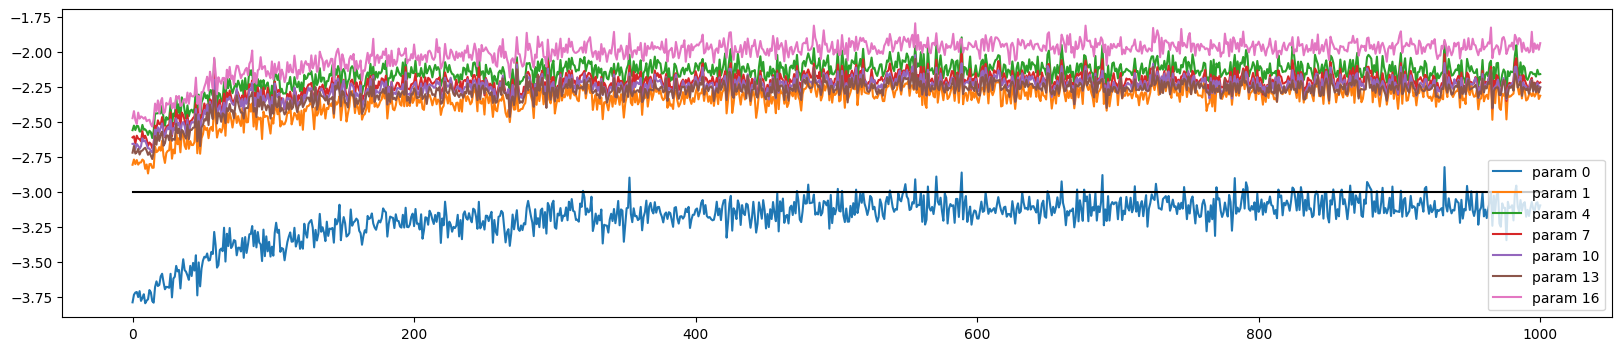

In [102]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append("param %d" % i)
plt.plot([0, len(ud)], [-3, -3], "k")  # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)

In [103]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    emb = C[x]  # (N, block_size, n_embd)
    x = emb.view(emb.shape[0], -1)  # concat into (N, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())


# put layers into eval mode
for layer in layers:
    layer.training = False
split_loss("train")
split_loss("val")

train 2.4002976417541504
val 2.398247003555298


In [104]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])]  # (1,block_size,n_embd)
        x = emb.view(emb.shape[0], -1)  # concatenate the vectors
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print("".join(itos[i] for i in out))  # decode and print the generated word

carpah.
qarlileif.
jmrix.
thty.
sacansa.
jazhnte.
dpn.
arciigqeiunellaia.
chriiv.
kalein.
dhlm.
join.
qhinn.
sroin.
arian.
quiqaelogiearyxix.
kaeklinsan.
ed.
ecoia.
gtleley.


In [105]:
# DONE; BONUS content below, not covered in video

In [ ]:
# BatchNorm forward pass as a widget

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats
import numpy as np


def normshow(x0):
    g = torch.Generator().manual_seed(2147483647 + 1)
    x = torch.randn(5, generator=g) * 5
    x[0] = x0  # override the 0th example with the slider
    mu = x.mean()
    sig = x.std()
    y = (x - mu) / sig

    plt.figure(figsize=(10, 5))
    # plot 0
    plt.plot([-6, 6], [0, 0], "k")
    # plot the mean and std
    xx = np.linspace(-6, 6, 100)
    plt.plot(xx, stats.norm.pdf(xx, mu, sig), "b")
    xx = np.linspace(-6, 6, 100)
    plt.plot(xx, stats.norm.pdf(xx, 0, 1), "r")
    # plot little lines connecting input and output
    for i in range(len(x)):
        plt.plot([x[i], y[i]], [1, 0], "k", alpha=0.2)
    # plot the input and output values
    plt.scatter(x.data, torch.ones_like(x).data, c="b", s=100)
    plt.scatter(y.data, torch.zeros_like(y).data, c="r", s=100)
    plt.xlim(-6, 6)
    # title
    plt.title("input mu %.2f std %.2f" % (mu, sig))


interact(normshow, x0=(-30, 30, 0.5))

In [ ]:
# Linear: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

a = torch.randn((1000, 1), requires_grad=True, generator=g)  # a.grad = b.T @ c.grad
b = torch.randn((1000, 1000), requires_grad=True, generator=g)  # b.grad = c.grad @ a.T
c = b @ a
loss = torch.randn(1000, generator=g) @ c
a.retain_grad()
b.retain_grad()
c.retain_grad()
loss.backward()
print("a std:", a.std().item())
print("b std:", b.std().item())
print("c std:", c.std().item())
print("-----")
print("c grad std:", c.grad.std().item())
print("a grad std:", a.grad.std().item())
print("b grad std:", b.grad.std().item())

In [ ]:
# Linear + BatchNorm: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

n = 1000
# linear layer ---
inp = torch.randn(n, requires_grad=True, generator=g)
w = torch.randn((n, n), requires_grad=True, generator=g)  # / n**0.5
x = w @ inp
# bn layer ---
xmean = x.mean()
xvar = x.var()
out = (x - xmean) / torch.sqrt(xvar + 1e-5)
# ----
loss = out @ torch.randn(n, generator=g)
inp.retain_grad()
x.retain_grad()
w.retain_grad()
out.retain_grad()
loss.backward()

print("inp std: ", inp.std().item())
print("w std: ", w.std().item())
print("x std: ", x.std().item())
print("out std: ", out.std().item())
print("------")
print("out grad std: ", out.grad.std().item())
print("x grad std: ", x.grad.std().item())
print("w grad std: ", w.grad.std().item())
print("inp grad std: ", inp.grad.std().item())